In [4]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[1]  # adjust if needed
SRC_PATH = PROJECT_ROOT

sys.path.append(str(SRC_PATH))

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path

from sklearn.manifold import TSNE

from src.utils.supcon import SupConViT

import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

# Load helpers for data and model loading
from src.utils.transformations import get_transforms
from src.utils.dataloaders import get_test_dataloader
from src.utils.baseline_models import get_model

In [20]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
print(f"Using device: {device}")

Using device: cuda


In [21]:
MODEL_NAME = "vit_base_patch16_224"
MODEL_PATH = PROJECT_ROOT / "checkpoints" / "baseline" / f"baseline_{MODEL_NAME}.pt"
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"

In [22]:
 # Load Model
print(f"Loading model from {MODEL_PATH}...")
model = get_model(MODEL_NAME, num_classes=26, pretrained=False)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

Loading model from c:\Users\jeist\Documents\Kuliah\MITB\CS604\plant-disease-detection\checkpoints\baseline\baseline_vit_base_patch16_224.pt...


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [23]:
# Define test sets
test_sets = {
    "PV_Test": SPLITS_DIR / "pv_test.csv",
    "PlantDoc_Test": SPLITS_DIR / "plantdoc_test_mapped.csv",
}


# Get appropriate transforms
_, _, transform_test = get_transforms(
    model, model_name=MODEL_NAME, image_size=224
)

# Create DataLoaders
pv_test_dataloader = get_test_dataloader(
    test_sets["PV_Test"], root_dir=PROJECT_ROOT, batch_size=32, transforms=transform_test
)
plantdoc_test_dataloader = get_test_dataloader(
    test_sets["PlantDoc_Test"], root_dir=PROJECT_ROOT, batch_size=32, transforms=transform_test
)

In [24]:
len(pv_test_dataloader.dataset), len(plantdoc_test_dataloader.dataset)

(3606, 219)

In [27]:
def get_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            if isinstance(model, SupConViT):
                outputs = model.backbone.forward_features(images)
            else:
                outputs = model.forward_features(images)
            features.append(outputs[:, 0].cpu().numpy())
            labels.append(targets.cpu())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

In [28]:
# Get features for PV test set
pv_features, pv_labels = get_features(model, pv_test_dataloader)

# Get features for PlantDoc test set
plantdoc_features, plantdoc_labels = get_features(model, plantdoc_test_dataloader)

Extracting features: 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]


In [29]:
df_labels = pd.read_csv(SPLITS_DIR / "label_space.csv")

# labels to dict
label_dict = dict(zip(df_labels["canonical_id"], df_labels["canonical_label"]))

In [30]:
def plot_embeddings(embeddings, labels, title, marker="o"):
    cmap = plt.cm.get_cmap("tab20", 26)
    plt.figure(figsize=(10, 8))
    for id, label in label_dict.items():
        idx = labels == id
        plt.scatter(embeddings[idx, 0], embeddings[idx, 1], color=cmap(id), label=label, alpha=0.7, marker=marker)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [31]:
def plot_together(embeddings1, labels1, embeddings2, labels2, title="tSNE Embeddings Comparison"):
    cmap = plt.cm.get_cmap("tab20", 26)
    plt.figure(figsize=(12, 10))
    
    for id, label in label_dict.items():
        idx1 = labels1 == id
        plt.scatter(embeddings1[idx1, 0], embeddings1[idx1, 1], color=cmap(id), label=f"{label} (PV)", alpha=0.7, marker="+")
        idx2 = labels2 == id
        plt.scatter(embeddings2[idx2, 0], embeddings2[idx2, 1], color=cmap(id), label=f"{label} (PlantDoc)", alpha=0.7, marker="x")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

C:\Users\jeist\AppData\Local\Temp\ipykernel_33712\2017335324.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 26)


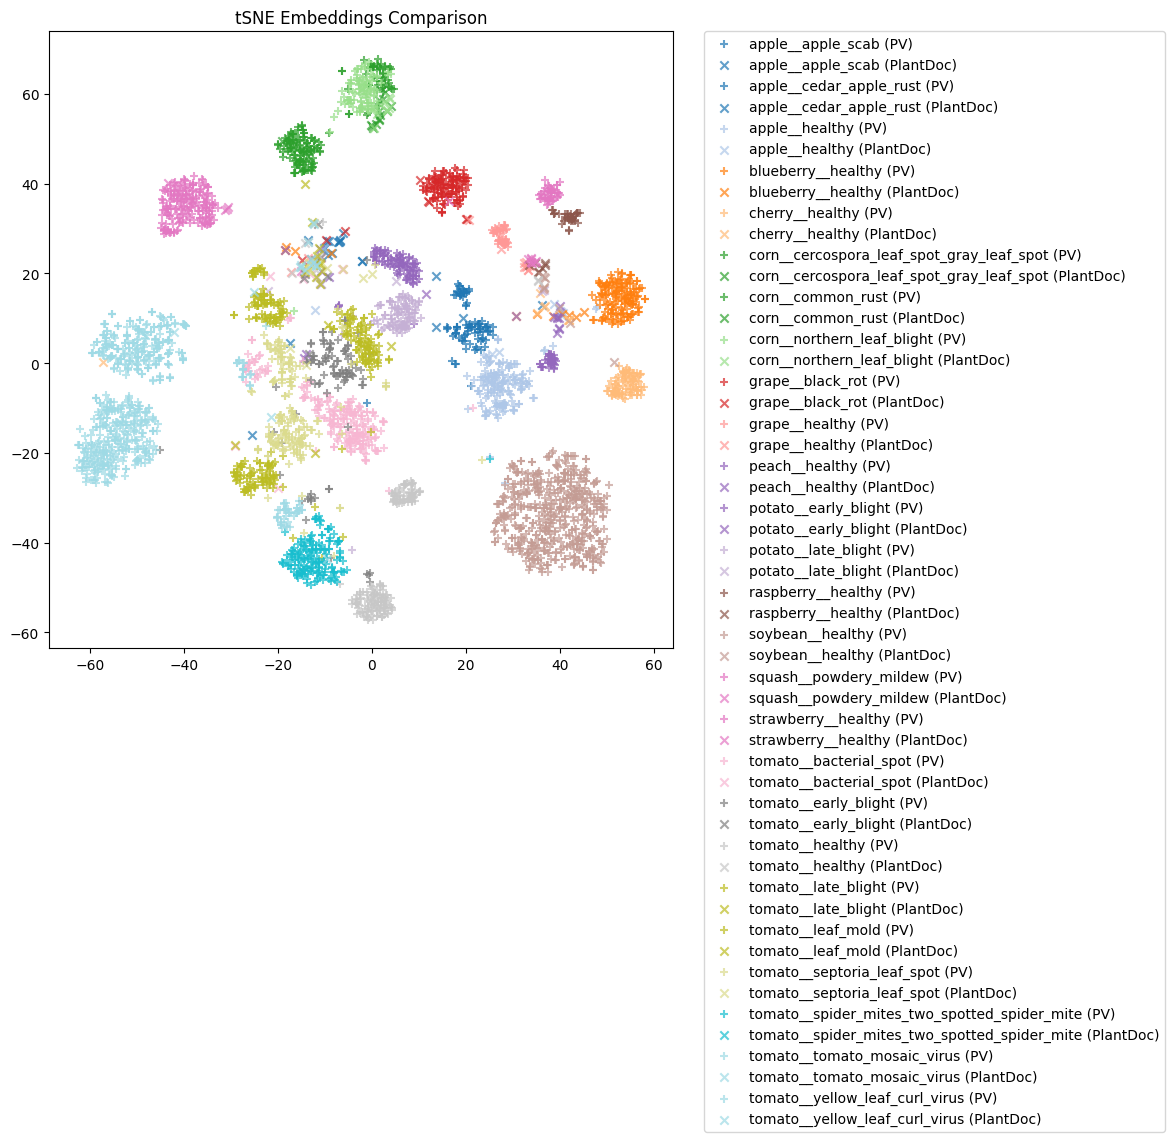

In [32]:
features_combined = np.concatenate([pv_features, plantdoc_features])
labels_combined = np.concatenate([pv_labels, plantdoc_labels])
tsne_combined = TSNE(n_components=2, random_state=42)
embeddings_combined_2d = tsne_combined.fit_transform(features_combined)

# Number of samples
n_pv = len(pv_features)
n_plantdoc = len(plantdoc_features)

# Split embeddings
pv_2d = embeddings_combined_2d[:n_pv]
plantdoc_2d = embeddings_combined_2d[n_pv:]

plot_together(pv_2d, pv_labels, plantdoc_2d, plantdoc_labels)

C:\Users\jeist\AppData\Local\Temp\ipykernel_33712\2100065658.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 26)


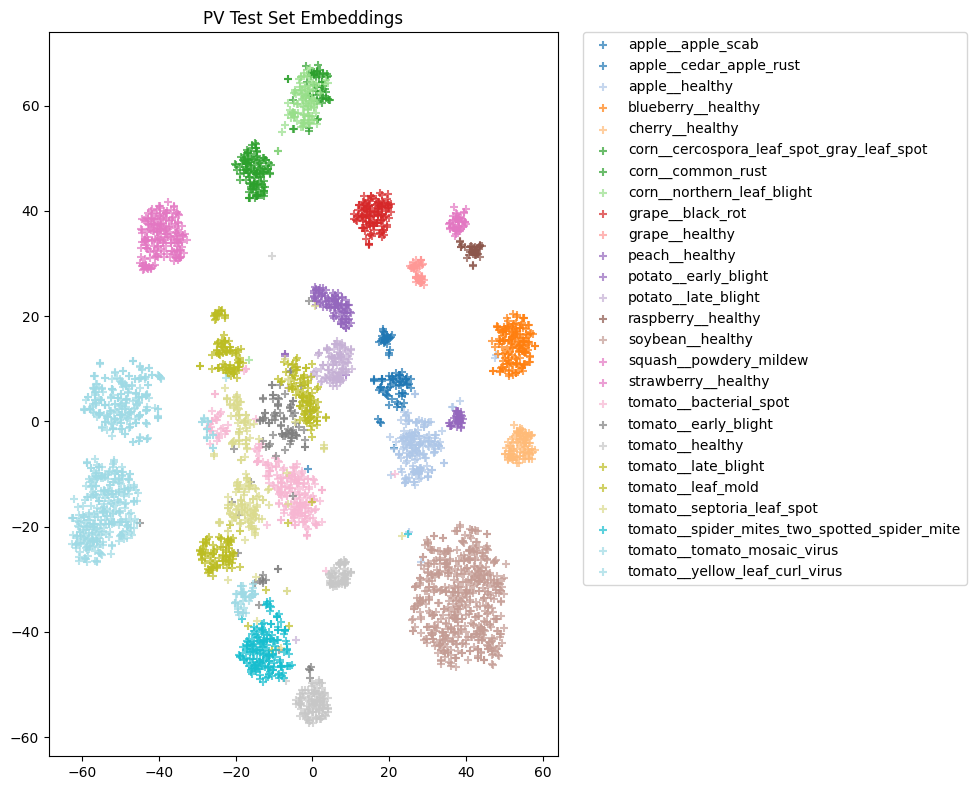

In [33]:
plot_embeddings(pv_2d, pv_labels, "PV Test Set Embeddings", marker="+")

C:\Users\jeist\AppData\Local\Temp\ipykernel_33712\2100065658.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 26)


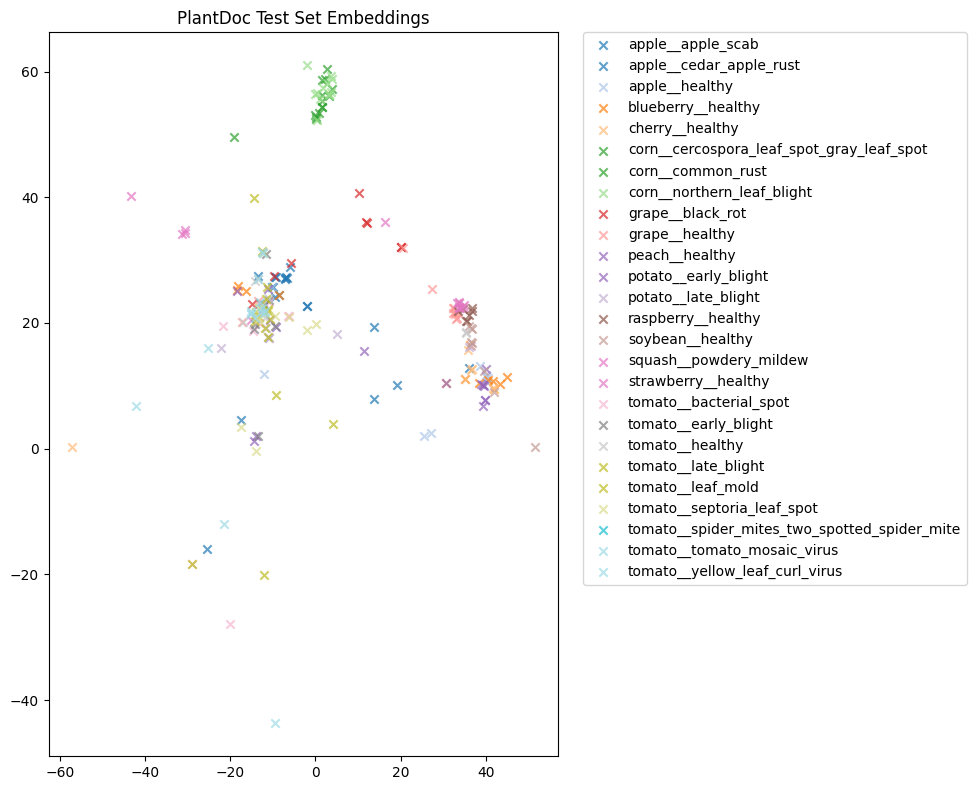

In [34]:
plot_embeddings(plantdoc_2d, plantdoc_labels, "PlantDoc Test Set Embeddings", marker="x")

**Inspect SupCon Embeddings**

In [35]:
SUPCON_MODEL_PATH = PROJECT_ROOT / "checkpoints" / "supcon" / f"supcon_{MODEL_NAME}.pt"

In [39]:
print(f"Loading model from {SUPCON_MODEL_PATH}...")
backbone = get_model(MODEL_NAME, num_classes=26, pretrained=False)
model = SupConViT(backbone, backbone_name=MODEL_NAME, num_classes=26)
checkpoint = torch.load(SUPCON_MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
print("Model loaded!")

Loading model from c:\Users\jeist\Documents\Kuliah\MITB\CS604\plant-disease-detection\checkpoints\supcon\supcon_vit_base_patch16_224.pt...
Model loaded!


In [40]:
# Define test sets
test_sets = {
    "PV_Test": SPLITS_DIR / "pv_test.csv",
    "PlantDoc_Test": SPLITS_DIR / "plantdoc_test_mapped.csv",
}


# Get appropriate transforms
_, _, transform_test = get_transforms(
    backbone, model_name=MODEL_NAME, image_size=224
)

# Create DataLoaders
pv_test_dataloader = get_test_dataloader(
    test_sets["PV_Test"], root_dir=PROJECT_ROOT, batch_size=32, transforms=transform_test
)
plantdoc_test_dataloader = get_test_dataloader(
    test_sets["PlantDoc_Test"], root_dir=PROJECT_ROOT, batch_size=32, transforms=transform_test
)

In [41]:
# Get features for PV test set
pv_features, pv_labels = get_features(model, pv_test_dataloader)

# Get features for PlantDoc test set
plantdoc_features, plantdoc_labels = get_features(model, plantdoc_test_dataloader)

Extracting features: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


In [42]:
df_labels = pd.read_csv(SPLITS_DIR / "label_space.csv")

# labels to dict
label_dict = dict(zip(df_labels["canonical_id"], df_labels["canonical_label"]))

C:\Users\jeist\AppData\Local\Temp\ipykernel_33712\2017335324.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 26)


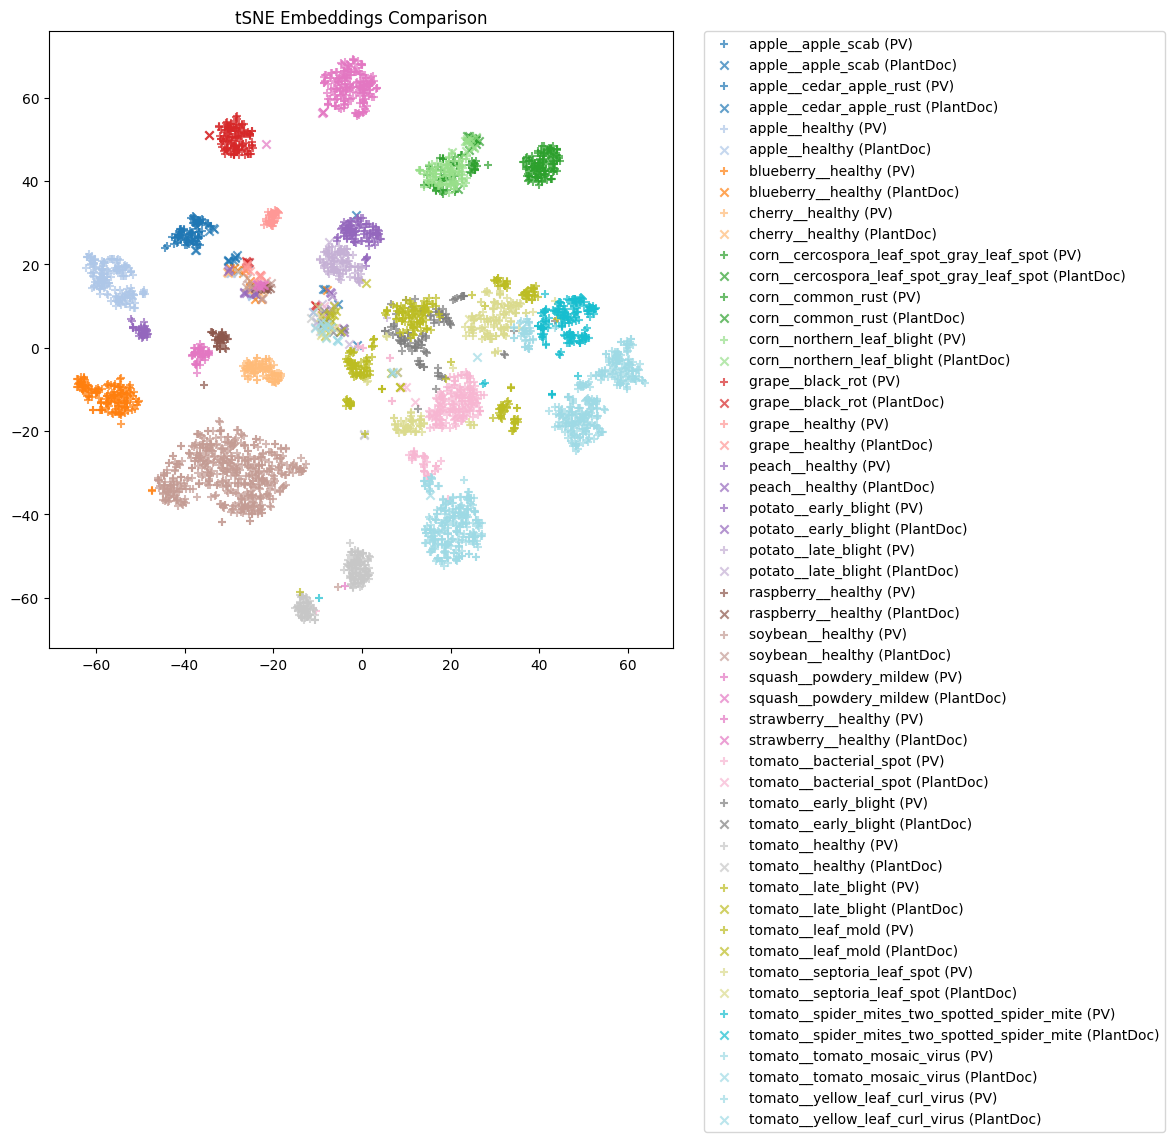

In [43]:
features_combined = np.concatenate([pv_features, plantdoc_features])
labels_combined = np.concatenate([pv_labels, plantdoc_labels])
tsne_combined = TSNE(n_components=2, random_state=42)
embeddings_combined_2d = tsne_combined.fit_transform(features_combined)

# Number of samples
n_pv = len(pv_features)
n_plantdoc = len(plantdoc_features)

# Split embeddings
pv_2d = embeddings_combined_2d[:n_pv]
plantdoc_2d = embeddings_combined_2d[n_pv:]

plot_together(pv_2d, pv_labels, plantdoc_2d, plantdoc_labels)

C:\Users\jeist\AppData\Local\Temp\ipykernel_33712\2100065658.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 26)


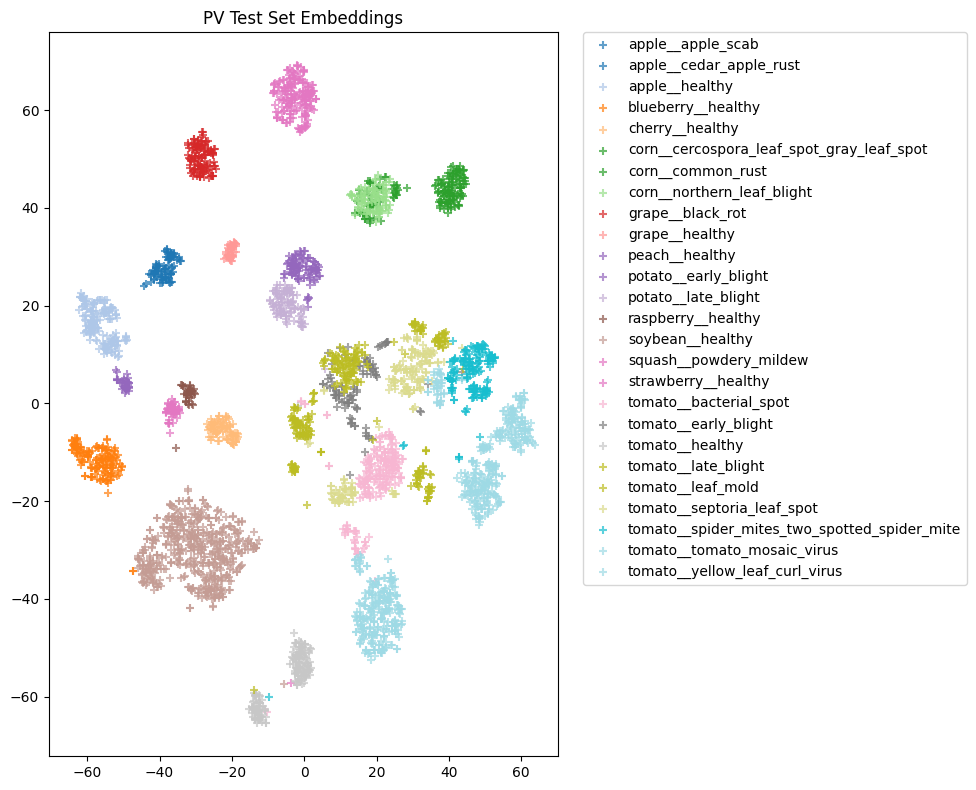

In [44]:
plot_embeddings(pv_2d, pv_labels, "PV Test Set Embeddings", marker="+")

C:\Users\jeist\AppData\Local\Temp\ipykernel_33712\2100065658.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 26)


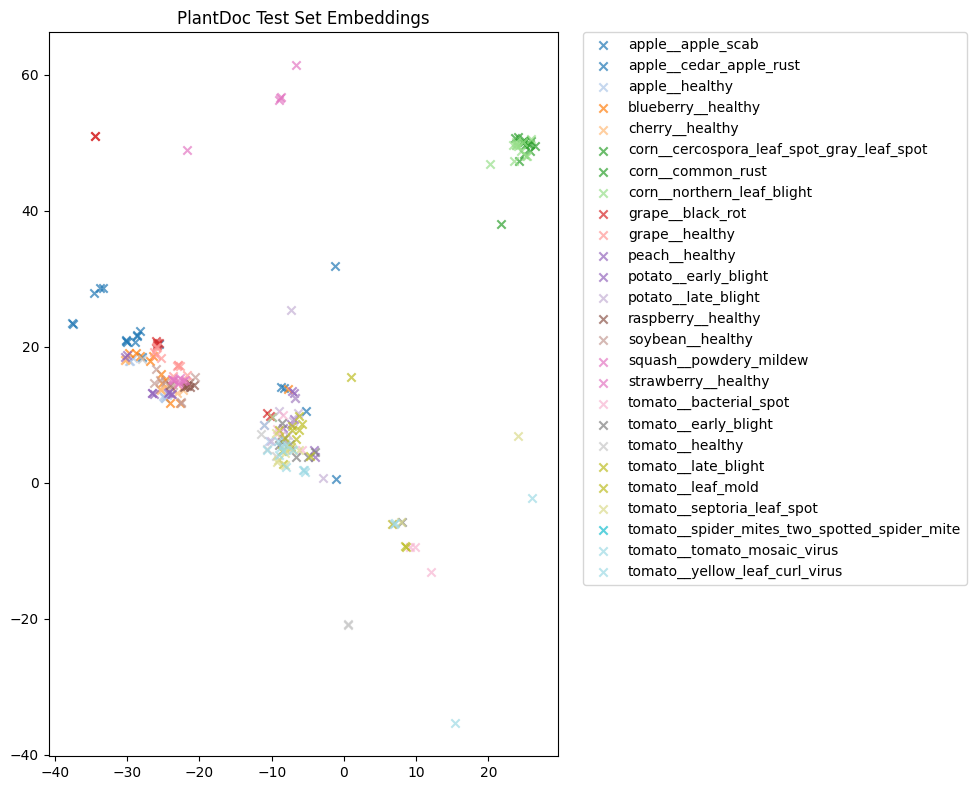

In [45]:
plot_embeddings(plantdoc_2d, plantdoc_labels, "PlantDoc Test Set Embeddings", marker="x")